In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import re

from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import numpy as np
import fbprophet
from fbprophet import Prophet
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from pylab import rcParams

import logging

from sklearn.metrics import mean_absolute_error


In [107]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    #pd.rolling_mean(timeseries, window=12)
    rolstd =  pd.Series(timeseries).rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    # dftest = adfuller(timeseries, autolag='AIC')
    dftest = adfuller(timeseries)
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


In [108]:
LME_futures = pd.read_excel('forecasting_raw_data/LME Futures Price.xlsx')
LME_futures = LME_futures.iloc[3:, 1:]
#LME_futures['Unnamed: 1'] = pd.datetime(LME_futures['Unnamed: 1'])
LME_futures.index = LME_futures['Unnamed: 1']



LME_futures = LME_futures.iloc[:, 1:]
LME_futures = LME_futures[LME_futures.index.year>=2000]
LME_futures.isnull().sum()
LME = LME_futures.iloc[:, 0]
LME = LME.astype(float)

#### Take Out Trend

In [109]:
LME = LME.resample('W').mean()

LME

LME_log = np.log(LME)

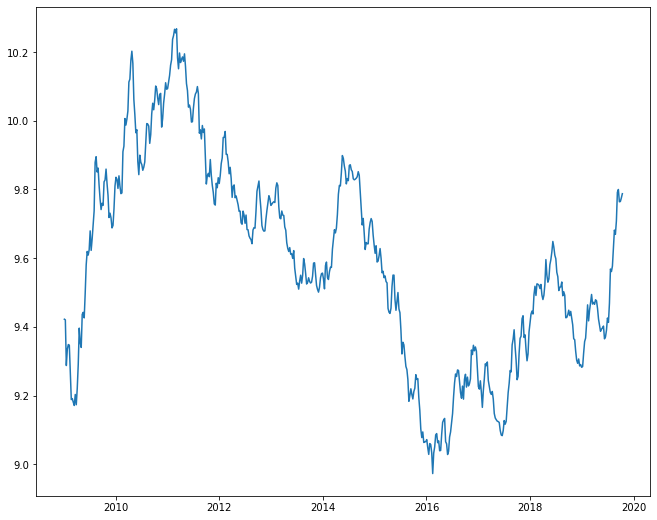

In [110]:
rcParams['figure.figsize'] = 11, 9

plt.plot(LME_log)
plt.show()

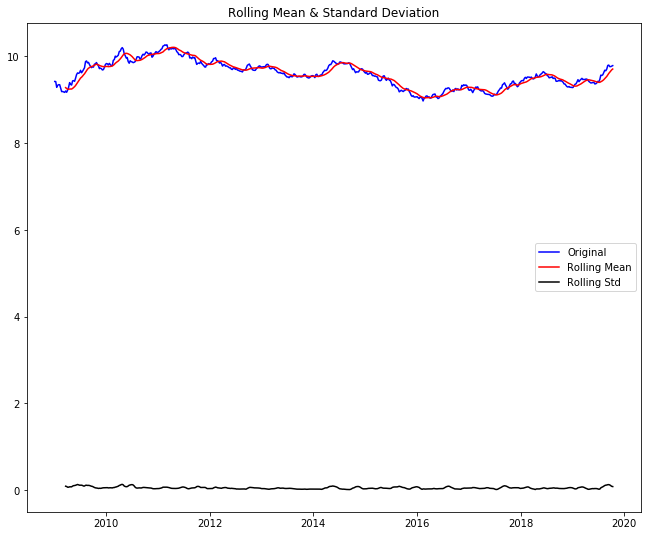

Results of Dickey-Fuller Test:
Test Statistic                  -1.669618
p-value                          0.446830
#Lags Used                       1.000000
Number of Observations Used    561.000000
Critical Value (1%)             -3.442060
Critical Value (5%)             -2.866706
Critical Value (10%)            -2.569521
dtype: float64


In [111]:
test_stationarity(LME_log)

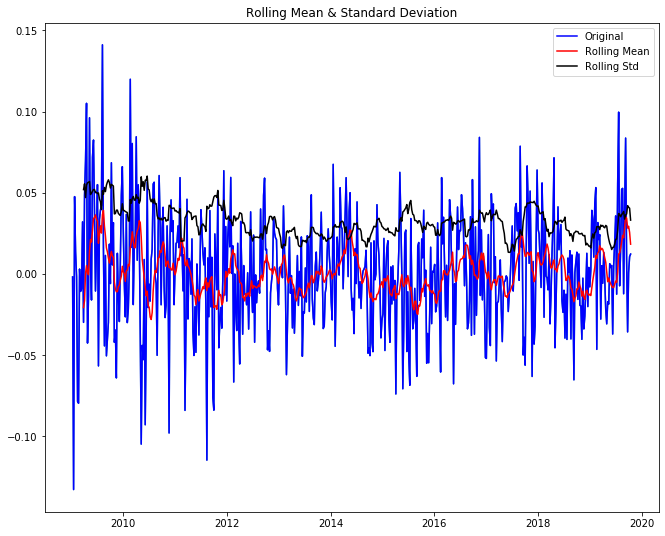

Results of Dickey-Fuller Test:
Test Statistic                 -19.309505
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    561.000000
Critical Value (1%)             -3.442060
Critical Value (5%)             -2.866706
Critical Value (10%)            -2.569521
dtype: float64


"\nmoving_avg = LME_log.rolling(window=30).mean()\nplt.plot(LME_log)\nplt.plot(moving_avg, color='red')\n#plt.axvline('2018-5-1', color='red', linestyle='--')\nplt.show()\n"

In [112]:
LME_diff = LME_log.diff().dropna()

plt.plot(LME_diff)
test_stationarity(LME_diff)

'''
moving_avg = LME_log.rolling(window=30).mean()
plt.plot(LME_log)
plt.plot(moving_avg, color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()
'''

<class 'pandas.core.series.Series'>


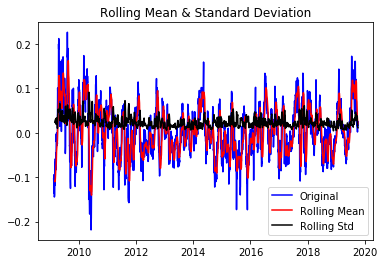

Results of Dickey-Fuller Test:
Test Statistic                -9.033624e+00
p-value                        5.361918e-15
#Lags Used                     9.000000e+00
Number of Observations Used    2.769000e+03
Critical Value (1%)           -3.432714e+00
Critical Value (5%)           -2.862584e+00
Critical Value (10%)          -2.567326e+00
dtype: float64


In [58]:
moving_diff = LME_log-moving_avg
moving_diff = moving_diff.dropna()
#moving_diff = moving_diff.to_frame()
print(type(moving_diff))
test_stationarity(moving_diff)


In [59]:
logging.getLogger().setLevel(logging.ERROR)

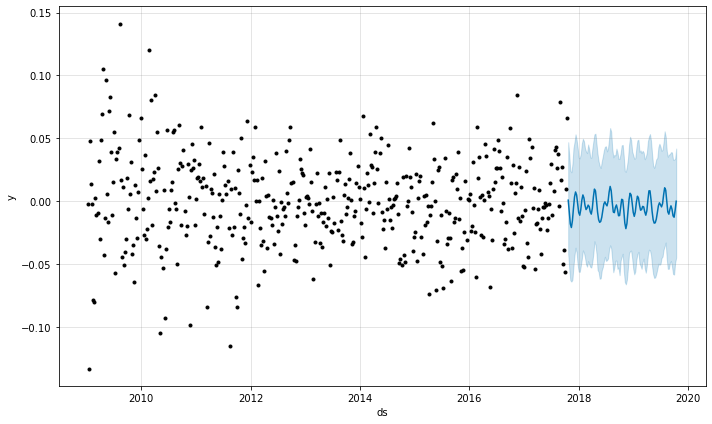

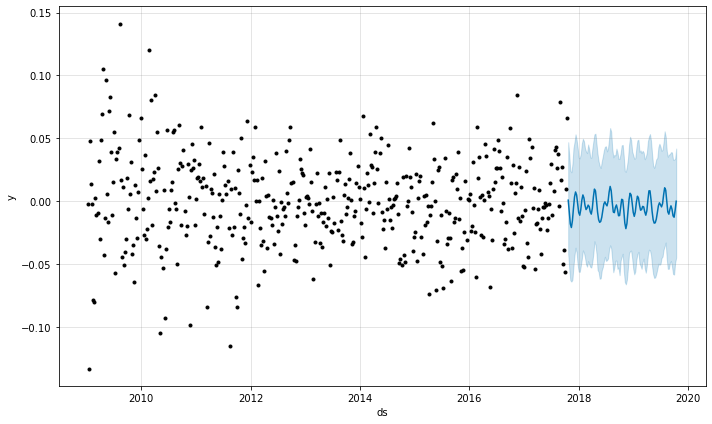

In [114]:
list_one = list(LME_diff.index)
list_two = list(LME_diff)
df = pd.DataFrame(list(zip(list_one, list_two)), columns = ['ds', 'y'])

prediction_size = 104
train_df = df[:-prediction_size]

m = Prophet()
m.fit(train_df)

test_df = df[-prediction_size:]
forecast = m.predict(test_df)
m.plot(forecast)
forecast.tail(20)

'''
future = m.make_future_dataframe(periods = prediction_size)

forecast = m.predict(future)
forecast.head()
'''


In [115]:
forecast.index = forecast['ds']
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
2017-10-22,2017-10-22,-0.003703,-0.041841,0.046920,-0.003703,-0.003703,0.004568,0.004568,0.004568,0.004568,0.004568,0.004568,0.0,0.0,0.0,0.000865
2017-10-29,2017-10-29,-0.003718,-0.054001,0.036745,-0.003718,-0.003718,-0.004680,-0.004680,-0.004680,-0.004680,-0.004680,-0.004680,0.0,0.0,0.0,-0.008398
2017-11-05,2017-11-05,-0.003732,-0.062720,0.024219,-0.003732,-0.003732,-0.014224,-0.014224,-0.014224,-0.014224,-0.014224,-0.014224,0.0,0.0,0.0,-0.017956
2017-11-12,2017-11-12,-0.003747,-0.063868,0.023004,-0.003747,-0.003747,-0.017119,-0.017119,-0.017119,-0.017119,-0.017119,-0.017119,0.0,0.0,0.0,-0.020866
2017-11-19,2017-11-19,-0.003761,-0.062350,0.029454,-0.003761,-0.003761,-0.011733,-0.011733,-0.011733,-0.011733,-0.011733,-0.011733,0.0,0.0,0.0,-0.015494


## Back to Scale before Performance Analysis

In [122]:
# FOR CUMULATIVE MOVING AVERAGE MODELING 

yhat = forecast['yhat']
y = moving_diff['2018-05-15':]
shifted_by_avg = moving_avg['2018-05-15':]

scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]
scaled_yhat

scaled_y =  moving_diff['2018-05-15':] + moving_avg['2018-05-15':]
scaled_y

actual_y = LME_log['2018-05-15':]


In [153]:
# FOR LOG/DIFF MODELING 

yhat = forecast['yhat']
y = LME_diff['2017-10-22':]

# !!! Backwards diff
start_price = LME_log.first('D')

#scaled_yhat =forecast['yhat'].rolling(2).sum().shift(-1)
scaled_yhat = start_price.append(forecast['yhat']).cumsum().dropna()
scaled_yhat = scaled_yhat['2017-10-22':]


scaled_y = start_price.append(LME_diff).cumsum().dropna()
scaled_y = scaled_y['2017-10-22':]

#shifted_by_avg = moving_avg['2018-05-15':]

#scaled_yhat = forecast['yhat'] + moving_avg['2018-05-15':]



actual_y = LME_log['2017-10-22':]



In [155]:
frame = { 'scaled_yhat': scaled_yhat, 'scaled_y': scaled_y, 'actual y': actual_y } 
  
results = pd.DataFrame(frame) 
results.head()

,scaled_yhat,scaled_y,actual y
2017-10-22,9.423045,9.366318,9.366318
2017-10-29,9.414647,9.372774,9.372774
2017-11-05,9.396691,9.423757,9.423757
2017-11-12,9.375825,9.432235,9.432235
2017-11-19,9.360331,9.369001,9.369001


In [156]:
results['error'] = results['scaled_y'] - results['scaled_yhat']
results.head()

results['unlogged_scaled_yhat'] = np.exp(results['scaled_yhat'])
results['original_y'] = LME['2017-10-22':]


In [157]:
results['error'] = results['original_y'] - results['unlogged_scaled_yhat']

# Mean error results
print(np.abs(results['error']).mean())

3355.681354940981


In [158]:
results.head()

,scaled_yhat,scaled_y,actual y,error,unlogged_scaled_yhat,original_y
2017-10-22,9.423045,9.366318,9.366318,-682.195327,12370.195327,11688.0
2017-10-29,9.414647,9.372774,9.372774,-503.048214,12266.748214,11763.7
2017-11-05,9.396691,9.423757,9.423757,330.552032,12048.447968,12379.0
2017-11-12,9.375825,9.432235,9.432235,684.749094,11799.650906,12484.4
2017-11-19,9.360331,9.369001,9.369001,101.164474,11618.235526,11719.4


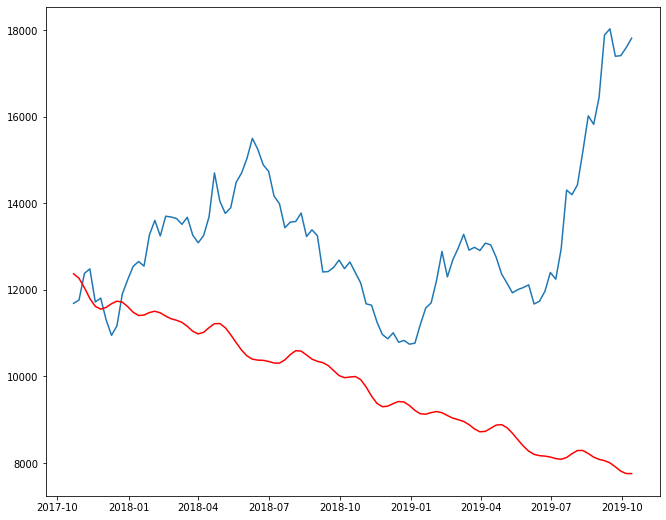

In [159]:
plt.plot(results['original_y'])
plt.plot(results['unlogged_scaled_yhat'], color='red')
#plt.axvline('2018-5-1', color='red', linestyle='--')
plt.show()

In [160]:
mean_absolute_error(results['scaled_y'], results['scaled_yhat'] )


0.2945472233968838

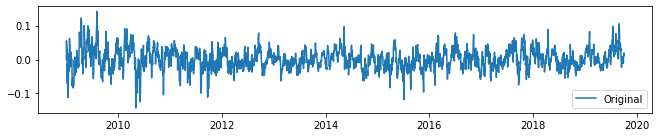

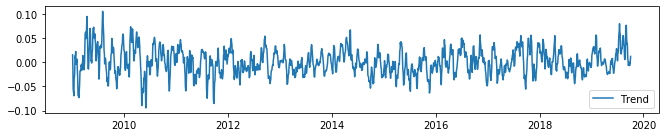

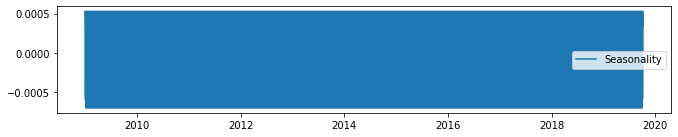

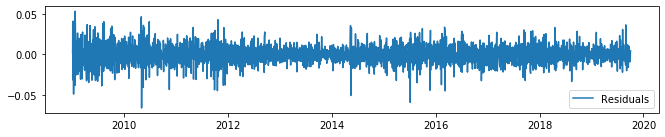

In [186]:
rcParams['figure.figsize'] = 11, 9
decomposition = sm.tsa.seasonal_decompose(exdiff)
#fig = decomposition.plot()
#plt.show()

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(exdiff, label='Original')
plt.legend(loc='best')
plt.show()

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.show()

plt.subplot(413)
plt.plot(seasonality, label='Seasonality')
plt.legend(loc='best')
plt.show()

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

In [187]:
exdiff.to_csv('exdiff_preprocessed.csv', index=True, header=True)

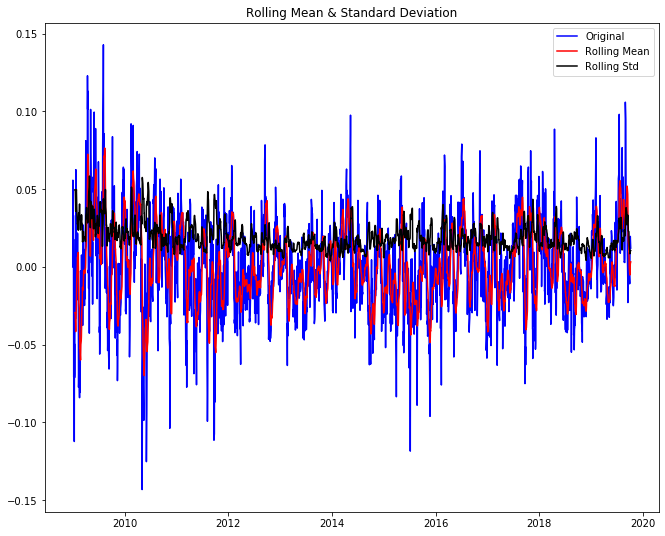

Results of Dickey-Fuller Test:
Test Statistic                -1.621079e+01
p-value                        3.988426e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.807000e+03
Critical Value (1%)           -3.432682e+00
Critical Value (5%)           -2.862570e+00
Critical Value (10%)          -2.567318e+00
dtype: float64


In [66]:
df = pd.read_csv('exdiff_preprocessed.csv')
df.index = df['Unnamed: 1']
df = df.iloc[:, 1:]
df.head()

df = df['Cash Price ($/MT)'].squeeze()
df.index = pd.to_datetime(df.index)
test_stationarity(df)

# Modeling

https://towardsdatascience.com/time-series-forecasting-with-prophet-54f2ac5e722e

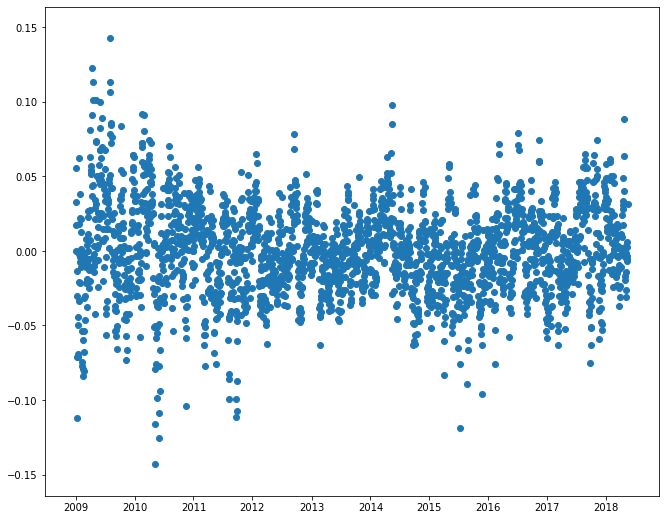

In [176]:
plt.scatter(train_df['ds'], train_df['y'])

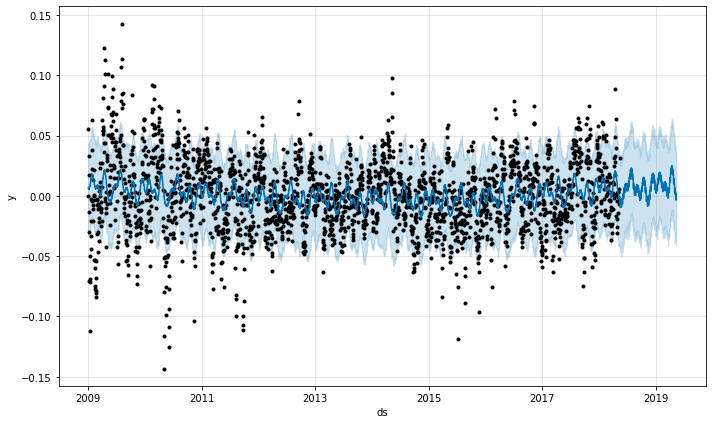

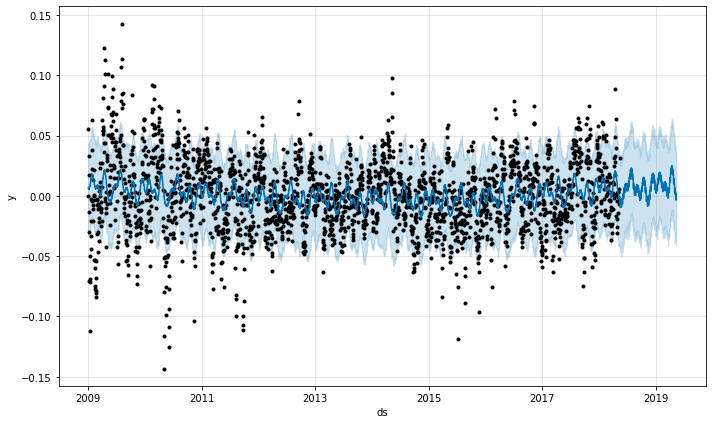

In [88]:
m.plot(forecast)

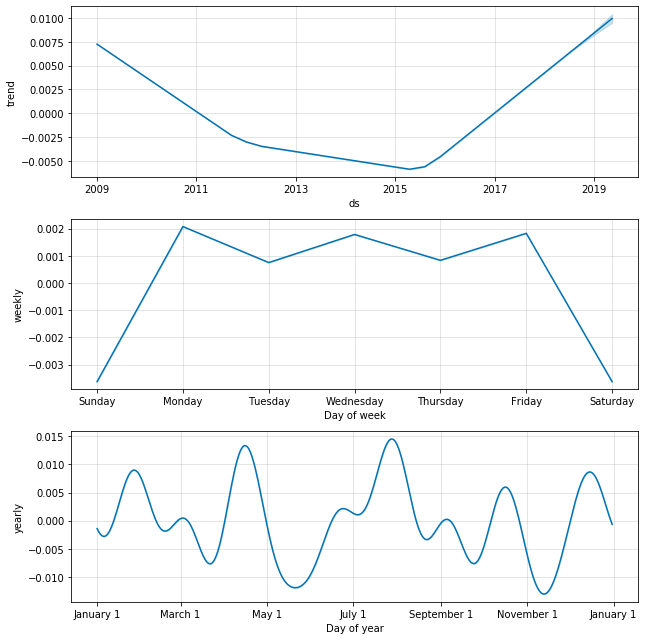

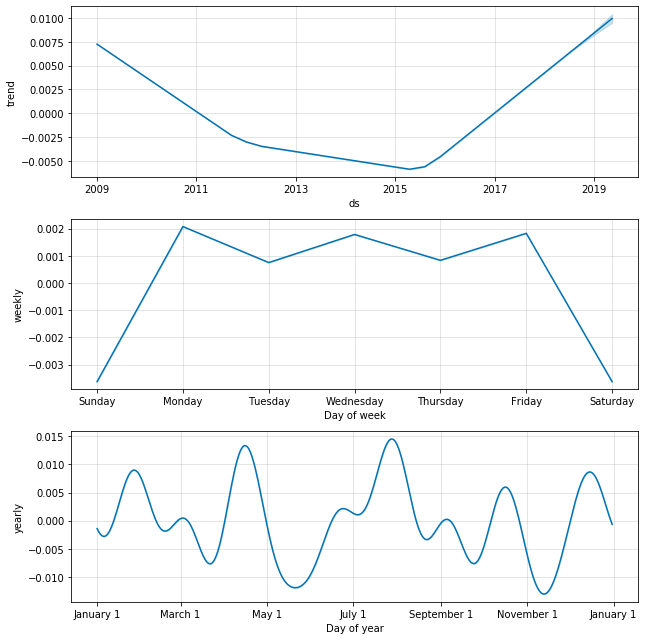

In [89]:
m.plot_components(forecast)

In [42]:
'''Joins predicted values with actual values'''
def make_comparison_dataframe(historical, forecast):
    
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

# Creating comparison dataframe
cmp_df = make_comparison_dataframe(df, forecast)



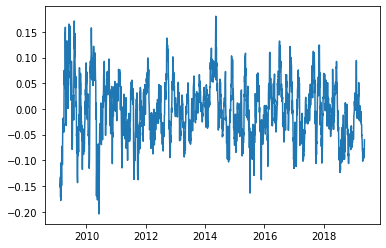

In [49]:
cmp_df['error'] =  cmp_df['y'] - cmp_df['yhat']
cmp_df.head()
plt.plot(cmp_df['error'])

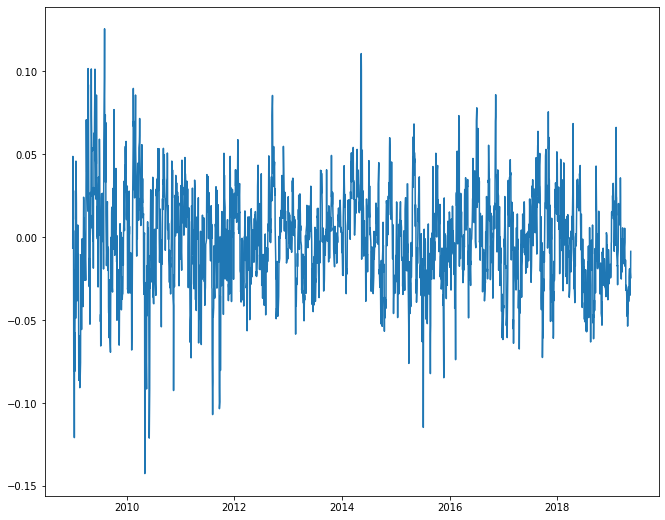

In [151]:
plt.plot(cmp_df['error'])

In [51]:
cmp_df = cmp_df.dropna()

def calculate_forecast_errors(df, prediction_size):
    df = df.copy()
    df['error'] = df['y'] - df['yhat']
    df['percentage'] = 100*df['error']/df['y']
    
    
    predicted_part = df[-prediction_size:]
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    print(predicted_part.head())
    return {'MAPE': error_mean('percentage'), 'MAE': error_mean('error')}

for err_name, err_value in calculate_forecast_errors(cmp_df.dropna(), prediction_size).items():
    print(err_name, err_value)

                yhat  yhat_lower  yhat_upper         y     error  percentage
ds                                                                          
2017-12-20  0.030911   -0.038317    0.101200  0.042610  0.011699   27.455771
2017-12-21  0.030106   -0.045255    0.099914  0.046177  0.016070   34.801897
2017-12-22  0.030545   -0.037697    0.100828  0.051237  0.020692   40.384256
2017-12-25  0.029742   -0.038494    0.100844  0.052215  0.022473   43.039938
2017-12-26  0.027537   -0.041608    0.098748  0.051225  0.023688   46.242715
MAPE 570.8182329084178
MAE 0.04271461087194927


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

def root_mean_squared_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.sqrt(((y_pred - y_true) **2).mean())
    #return np.mean(np.abs((y_true - y_pred) / y_true))*100


In [46]:
np.sqrt(9)

3.0

In [47]:
print('mape', mean_absolute_percentage_error(cmp_df['y'], cmp_df['yhat']))

print('rmse', root_mean_squared_error(cmp_df['y'], cmp_df['yhat']))

mape 219.83967767924054
rmse 0.05529372373011725
